# Show Atlantic water presence

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.patches as patches
import cmocean
import pickle
import matplotlib
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

# Resolution of grid cells to show in figure:
grid_reso  = 10

# Colors:
land_color  = '#a9a7a2'
land_outline_color = '#373736'

# transect coordinates:
BB_coords = (1470,1471,515,670) # Baffin Bay
DS_coords = (1290,1291,502,630) # Davis Strait (jet)

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,778,798) # Northern Canada Basin 
bdy_WCB = (2168,2178,390,797) # Western Canada Basin 
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,293,303) # Hudson Bay

#### Load files:

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

# General file:
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept  = mesh['hdept'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
mesh_gdepw  = mesh['gdepw_1d'].values[0,:]

In [4]:
# transect coordinates
DS_lons  = mesh_lon[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_lats  = mesh_lat[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_deps  = bathy_masked[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]
# DS_depsV = bathy_maskedV[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]

In [5]:
# BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_y2002m01.nc','r')
BC1     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2015m09.nc','r')
BC2     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Labrador_Sea/Pb_OBC_y2015m09.nc','r')
dPb_S1  = np.array(BC1.variables['dPb_S']).reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2])
dPb_S2  = np.array(BC2.variables['dPb_S']).reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2])

# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

BC1.close()
BC2.close()

In [6]:
folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/'
comp1   = xr.open_dataset(f'{folder1}climatology-2007-onwards.nc')
comp2   = xr.open_dataset(f'{folder1}climatology-LS-2007-onwards.nc')
dPb_ref = comp1['dissolpb'].values[:,0,:,:,:]
dPb_LS  = comp2['dissolpb'].values[:,0,:,:,:]

delta_dPb         = (dPb_LS - dPb_ref).mean(axis=0) # initially look at mean over full time series, not monthly
delta_dPb_monthly = (dPb_LS - dPb_ref)

#### Functions

In [7]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [8]:
def get_boundary_depths(bdy_distance, bdy_ind, cell=0):
    
    model_depths    = np.zeros((len(mesh_depth), len(bdy_distance)))
    for n in range(0,len(bdy_distance)):         
        mesh_depth_adjusted = np.copy(mesh_gdepw)
        if (bdy_ind[1]-bdy_ind[0]) < (bdy_ind[3]-bdy_ind[2]): # depending on orientation of boundary
            bathy_ind           = mesh_mbathy[bdy_ind[0]+cell, bdy_ind[2]+n]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+cell, bdy_ind[2]+n]
        else:
            bathy_ind           = mesh_mbathy[bdy_ind[0]+n, bdy_ind[2]+cell]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+n, bdy_ind[2]+cell]

        model_depths[:,n]    = mesh_depth_adjusted
    
    return model_depths

#### Calculations

In [9]:
bdy_cell=5

DS_distance = calc_distance(DS_lats, DS_lons) 
S_distance  = calc_distance(dPb_S_lats[bdy_cell,:]   , dPb_S_lons[bdy_cell,:])    # Labrador Sea

In [10]:
LS_model_depths = get_boundary_depths(S_distance, bdy_LS,  cell=bdy_cell)
DS_model_depths = get_boundary_depths(DS_distance, DS_coords,  cell=0)

#### Figure:

In [11]:
cmap1 = cmocean.cm.rain
cmap1.set_bad(land_color, 1)   

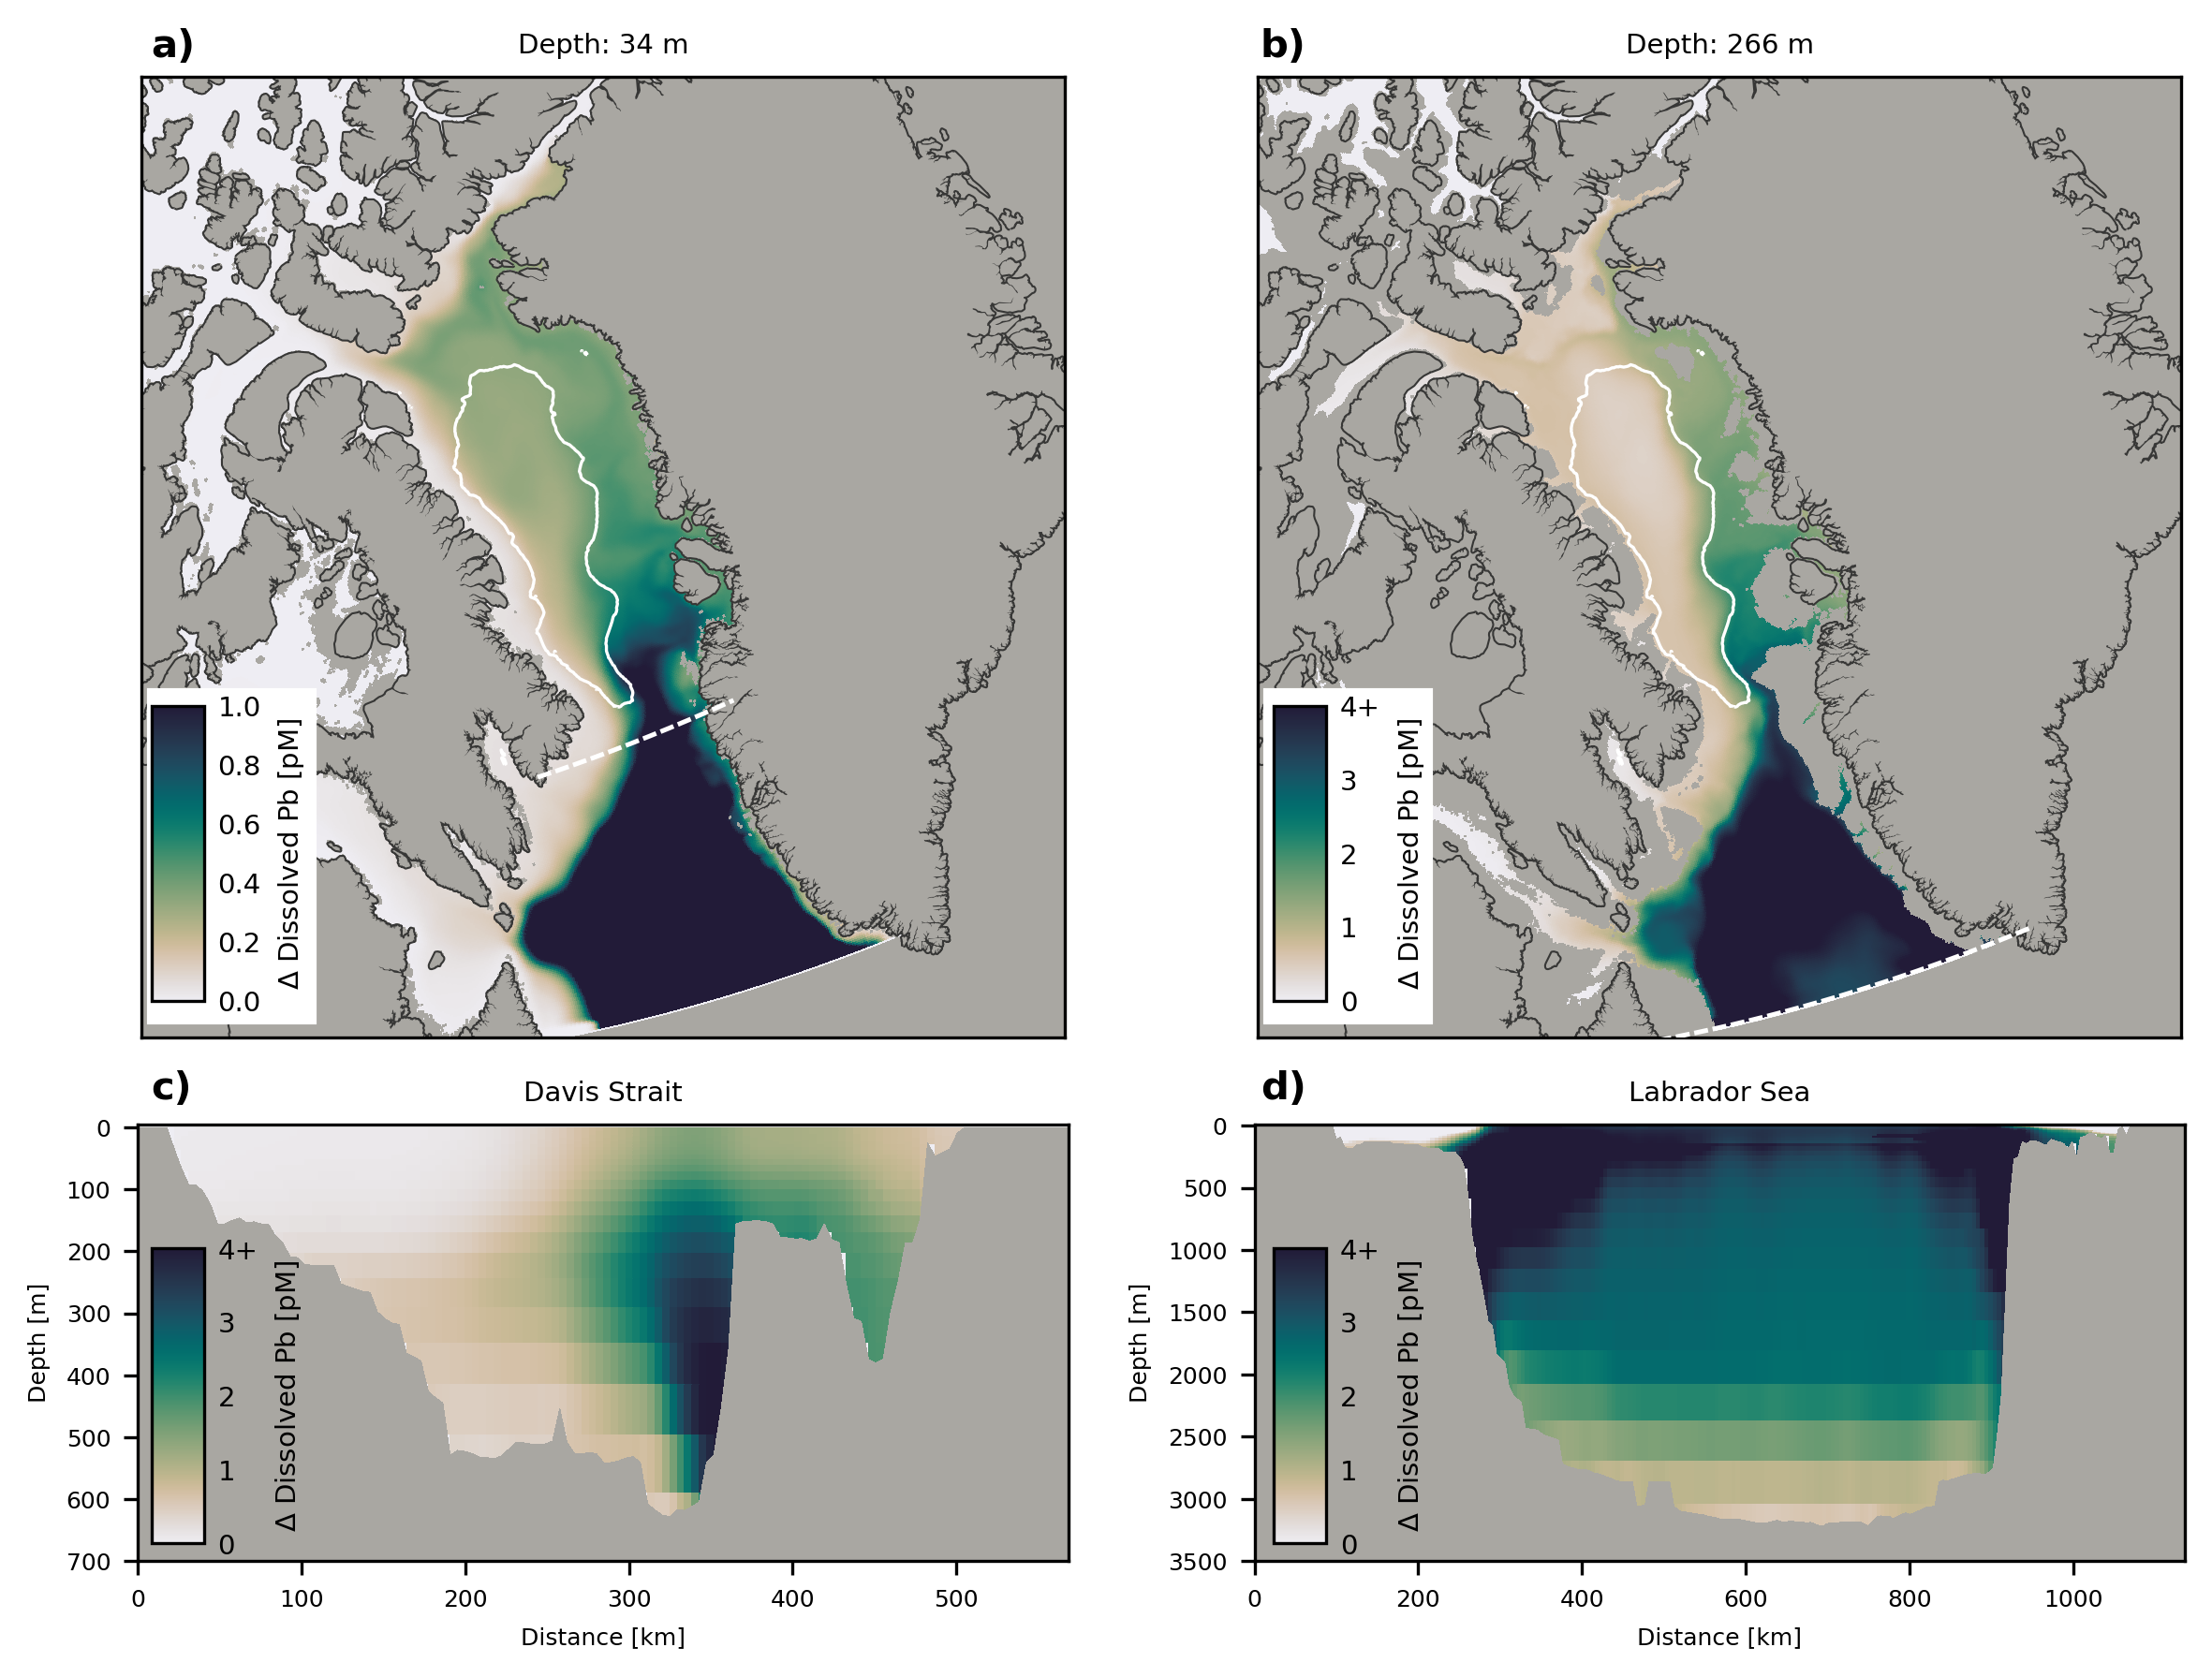

In [14]:
layer1 = 15; layer2 = 27;
vmax1 = 1; vmax2=4;

fig = plt.figure(figsize=(4.7*2,3.5*2), dpi=300)
gs  = fig.add_gridspec(3,2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])

# -------- maps ------------------------------------------------------------------------------
for axis in [ax1, ax2]:
    proj1=Basemap(projection='eqdc',lat_0 = 70.5, lon_0 = -60, resolution='i', width=2.5e6, height=2.6e6, ax=axis)
    proj1.drawcoastlines(color=land_outline_color, linewidth=1.0);
    proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    axis.set_facecolor(land_color)
    rect = patches.Rectangle((0.2e5, 0.4e5), 4.5e5, 9e5, edgecolor='w', facecolor='w', zorder=3)
    axis.add_patch(rect)
    proj1.contour(x[130:,:], y[130:,:], mesh_hdept[imin+130:imax,jmin:jmax], colors='w', linestyles='-', \
                  linewidths=0.8, levels=[1000], zorder=3, ax=axis)

ax1.plot(x[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 
         y[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 'w', linestyle=(0, (3, 1)), lw=1.2, zorder=4)
ax2.plot(x[bdy_LS[0]-imin,bdy_LS[2]-jmin:bdy_LS[3]-jmin], 
         y[bdy_LS[0]-imin,bdy_LS[2]-jmin:bdy_LS[3]-jmin], 'w', linestyle=(0, (3, 1)), lw=1.2, zorder=4)
    
CB1 = proj1.pcolormesh(x, y, delta_dPb[layer1]*1e12, cmap=cmap1, vmin=0, vmax=vmax1, ax=ax1) 
CB2 = proj1.pcolormesh(x, y, delta_dPb[layer2]*1e12, cmap=cmap1, vmin=0, vmax=vmax2, ax=ax2) 
proj1.pcolormesh(x, y, bathy_masked[layer1,imin:imax,jmin:jmax], \
               cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax1)
proj1.pcolormesh(x, y, bathy_masked[layer2,imin:imax,jmin:jmax], \
               cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax2)

ax1.set_title(f'Depth: {mesh_depth[layer1]:.0f} m', fontsize=7)
ax2.set_title(f'Depth: {mesh_depth[layer2]:.0f} m', fontsize=7)

# Color bar: ---------------
cbaxes1 = fig.add_axes([0.13, 0.41, 0.02, 0.15]);
cbaxes2 = fig.add_axes([0.555, 0.41, 0.02, 0.15]);
CBar1   = plt.colorbar(CB1, cax=cbaxes1); 
CBar2   = plt.colorbar(CB2, cax=cbaxes2); 
CBar2.ax.set_yticklabels(['0','1','2','3','4+'])
for cb in [CBar1, CBar2]:
    cb.set_label(r"$\Delta$ Dissolved Pb [pM]", fontsize=7)
    cb.ax.tick_params(axis='y', length=0, labelsize=7)

# ------- Davis Strait transect -----------------------------------------------------------------
ax3.set_xlabel('Distance [km]', fontsize=6)
ax3.set_ylabel('Depth [m]', fontsize=6)
ax3.invert_yaxis()
ax3.tick_params(axis='both', which='major', labelsize=6)  
ax3.set_ylim(700,-5)

Davis = delta_dPb[:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]

# Cross-section
xx, zz = np.meshgrid(DS_distance, mesh_gdepw)
CB3 = ax3.pcolormesh(xx, zz, Davis*1e12, vmin=0, vmax=vmax2, cmap=cmocean.cm.rain)
ax3.pcolormesh(xx, DS_model_depths, Davis, cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)
ax3.set_title('Davis Strait', fontsize=7)

# ------- Boundary condition transect -----------------------------------------------------------------
ax4.set_xlabel('Distance [km]', fontsize=6)
ax4.set_ylabel('Depth [m]', fontsize=6)
ax4.invert_yaxis()
ax4.tick_params(axis='both', which='major', labelsize=6)  
ax4.set_ylim(3500,-10)
    
# Labrador Sea:
xx, zz = np.meshgrid(S_distance, mesh_gdepw)
CB4 = ax4.pcolormesh(xx, zz, (dPb_S2[:,bdy_cell,:]-dPb_S1[:,bdy_cell,:])*1e12, vmin=0, vmax=vmax2, cmap=cmocean.cm.rain)
ax4.pcolormesh(xx, LS_model_depths, dPb_S1[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)
ax4.set_title('Labrador Sea', fontsize=7)

# Color bar: ---------------
cbaxes3 = fig.add_axes([0.13, 0.134, 0.02, 0.15]);
cbaxes4 = fig.add_axes([0.555, 0.134, 0.02, 0.15]);
CBar3   = plt.colorbar(CB3, cax=cbaxes3); 
CBar4   = plt.colorbar(CB4, cax=cbaxes4); 
CBar3.ax.set_yticklabels(['0','1','2','3','4+'])
CBar4.ax.set_yticklabels(['0','1','2','3','4+'])
for cb in [CBar3, CBar4]:
    cb.set_label(r"$\Delta$ Dissolved Pb [pM]", fontsize=7)
    cb.ax.tick_params(axis='y', length=0, labelsize=7)

# ------ Labels --------------------------------------------
fig.text(0.13, 0.89, 'a)', fontsize=10, weight='bold');
fig.text(0.55, 0.89, 'b)', fontsize=10, weight='bold');
fig.text(0.13, 0.36, 'c)', fontsize=10, weight='bold');
fig.text(0.55, 0.36, 'd)', fontsize=10, weight='bold');

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R5-Atlantic-influence.jpg', dpi=300, bbox_inches='tight')